KAIYUAN LI z5521676

Part 1

Question 1

(i) When we use r'[^\w\s]' to remove punctuation and other characters, we also eliminate symbols that are directly connected to letters or digits. In the context of this dataset, some symbols carry special meaning. For example, the track name l.i.t. becomes 'l', 'i', 't' after removal, and these individual characters are meaningless and introduce noise. Of course, there are also symbols in the dataset that are not very informative, such as the ® in bloodpop®. Therefore, we need to find a balanced approach. We begin by analyzing the dataset to identify all non-alphanumeric and non-space characters and count their occurrences, as shown in the code below:

In [3]:
import pandas as pd
import re
from collections import Counter

df = pd.read_csv("dataset.tsv", sep="\t")

text_data = ' '.join(df.astype(str).apply(' '.join, axis=1))

char = re.findall(r'[^\w\s]', text_data)

char_count = Counter(char)

char_df = pd.DataFrame(char_count.items(), columns=["Character", "Count"]).sort_values(by="Count", ascending=False)

print(char_df)

   Character  Count
2          .    116
0          '    109
4          )     97
1          (     97
6          &     58
3          ,     32
5          -     21
7          !     17
13         ’     12
10         /      8
16         ?      8
9          :      4
8          •      4
14         +      3
21         $      2
18         [      2
19         ]      2
22         "      2
17         –      1
15         =      1
20         %      1
12         ®      1
11         #      1


As we can see, the number of such symbols is not very large in this dataset, and the noise introduced by them is within an acceptable range, so we can choose to keep them. Interestingly, we also observed that some non-English characters, such as Korean, exist in the dataset. These characters are not removed by r'[^\w\s]', but they are later cleaned during the word_tokenize() step in the preprocessing pipeline. Therefore, whether we remove them using regular expressions at this stage has little impact on the final result.

Ultimately, I decided to use the regular expression r"[^\x20-\x7E]", which retains only ASCII printable characters. Compared to r'[^\w\s]', it preserves punctuation symbols while additionally removing special characters like Korean.

(ii) Splitting the dataset into a single training and testing set can lead to unstable evaluation results, as it is highly sensitive to the specific random split. Cross-validation helps mitigate this by performing multiple splits and averaging the results, providing a more reliable assessment of model performance. Therefore, in the following stages, I will use 5-fold cross-validation to balance training efficiency and evaluation stability.

Question 2

The preprocessing steps that I believe work best overall are as follows: lowercasing; using a regular expression to keep only ASCII printable characters (applied before tokenization, which helps preserve meaningful symbol-letter combinations such as "l.i.t." in track names); tokenization; removing stopwords using the NLTK stopword list; and applying lemmatization. Although lemmatization is slower than stemming, it is acceptable given the size of our dataset and generally provides better accuracy.

In [156]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Load dataset
df = pd.read_csv("dataset.tsv", sep="\t")

# Drop duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()

# Concatenate useful metadata into a new 'content' field
categories = ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']
df['content'] = df[categories].astype(str).agg(' '.join, axis=1)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\x20-\x7E]", '', text)  # keep only ASCII printable characters (question 1)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['Cleaned_content'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kgnew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kgnew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kgnew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kgnew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
print(df['Cleaned_content'].head())

0    loving real lake 2016 rock awake know go see t...
1    incubus summer 2019 rock summer pretty build s...
2    reignwolf hardcore 2016 blue lose deep catch b...
3    tedeschi truck band anyhow 2016 blue run bitte...
4    lukas nelson promise real started 2017 blue th...
Name: Cleaned_content, dtype: object


In [67]:
# Multinomial Naive Bayes model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

vectorizer = CountVectorizer()
X_mnb = vectorizer.fit_transform(df['Cleaned_content'])
y = df['topic']

mnb = MultinomialNB()

# 5-fold cross-validation (question 1)
y_mnb = cross_val_predict(mnb, X_mnb, y, cv=5)


print("MNB:")
print("Accuracy :", accuracy_score(y, y_mnb))
print("Precision:", precision_score(y, y_mnb, average='macro'))
print("Recall   :", recall_score(y, y_mnb, average='macro'))
print("F1 Score :", f1_score(y, y_mnb, average='macro'))


MNB:
Accuracy : 0.7885135135135135
Precision: 0.742063197385195
Recall   : 0.6968334244185204
F1 Score : 0.7110813499452033


Question 3

To understand the balance of the dataset, we choose to print the distribution of topics.

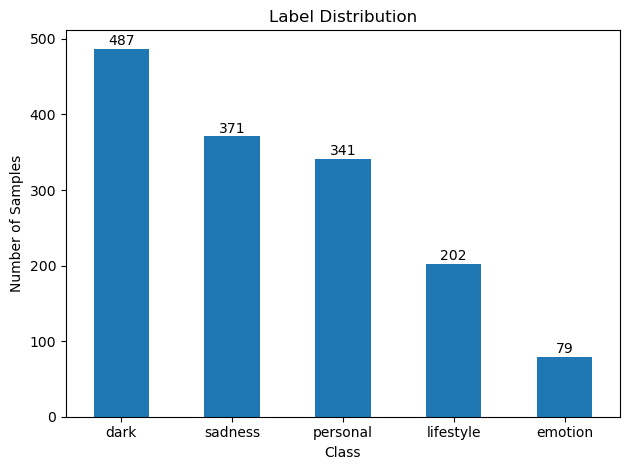

In [35]:
import matplotlib.pyplot as plt

y = df['topic']
counts = y.value_counts()

ax = counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.tight_layout()

for i, v in enumerate(counts):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')
    
plt.show()

In the figure, we can see that the maximum number of samples is for the topic dark with 487 entries, while the minimum is emotion with only 79. To comprehensively evaluate performance, we select Accuracy, Precision, Recall, and F1 Score as our metrics.

Accuracy measures the overall proportion of correctly predicted samples.

Precision aims to minimize false positives.

Recall aims to minimize false negatives.

F1 Score balances both precision and recall.

Since the dataset is imbalanced, we use macro-averaged precision, recall, and F1 score instead of weighted averaging, in order to treat smaller classes like emotion fairly.

In [61]:
# Bernoulli Naive Bayes 
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

vectorizer = CountVectorizer()
X_bnb = vectorizer.fit_transform(df['Cleaned_content'])
y = df['topic']

bnb = BernoulliNB()

# 5-fold cross-validation
y_bnb = cross_val_predict(bnb, X_bnb, y, cv=5)


print("BNB:")
print("Accuracy :", accuracy_score(y, y_bnb))
print("Precision:", precision_score(y, y_bnb, average='macro'))
print("Recall   :", recall_score(y, y_bnb, average='macro'))
print("F1 Score :", f1_score(y, y_bnb, average='macro'))

BNB:
Accuracy : 0.525
Precision: 0.3545134689366251
Recall   : 0.37749768110699794
F1 Score : 0.3326938401623275


In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

results = {
    "Accuracy": [
        accuracy_score(y, y_mnb),
        accuracy_score(y, y_bnb)
    ],
    "Precision (Macro)": [
        precision_score(y, y_mnb, average='macro'),
        precision_score(y, y_bnb, average='macro')
    ],
    "Recall (Macro)": [
        recall_score(y, y_mnb, average='macro'),
        recall_score(y, y_bnb, average='macro')
    ],
    "F1 Score (Macro)": [
        f1_score(y, y_mnb, average='macro'),
        f1_score(y, y_bnb, average='macro')
    ]
}

comparison_df = pd.DataFrame(results, index=["MultinomialNB", "BernoulliNB"])
print(comparison_df)


               Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)
MultinomialNB  0.788514           0.742063        0.696833          0.711081
BernoulliNB    0.525000           0.354513        0.377498          0.332694


From the table, we can conclude that the MNB model outperforms the BNB model across all evaluation metrics.

Question 4

Since the following tasks require the use of TF-IDF vectors, we replace CountVectorizer with TfidfVectorizer in this section. This also allows us to determine an appropriate value for N based on TF-IDF features, as the optimal number of features found using CountVectorizer may not directly apply when using TfidfVectorizer.

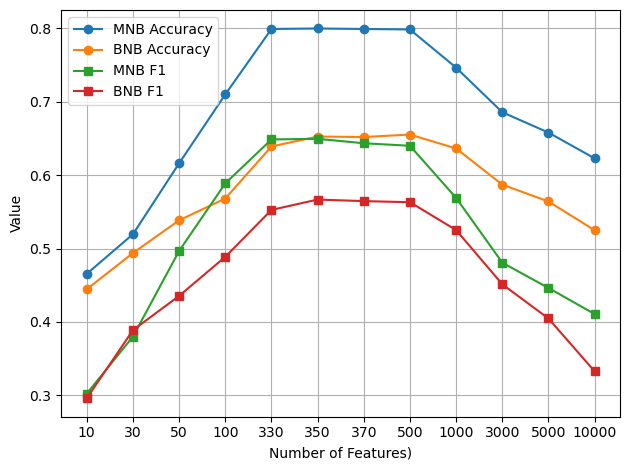

    n_features  MNB_Accuracy  BNB_Accuracy    MNB_F1    BNB_F1
0           10      0.465541      0.444595  0.302311  0.295975
1           30      0.519595      0.493919  0.380024  0.388811
2           50      0.616216      0.538514  0.496742  0.435490
3          100      0.710135      0.568243  0.588829  0.488748
4          330      0.799324      0.639189  0.648747  0.552690
5          350      0.800000      0.652703  0.649591  0.566771
6          370      0.799324      0.652027  0.643537  0.564685
7          500      0.798649      0.655405  0.640117  0.563187
8         1000      0.746622      0.636486  0.569092  0.525239
9         3000      0.685811      0.587162  0.480773  0.451341
10        5000      0.658108      0.564189  0.446315  0.404696
11       10000      0.622973      0.525000  0.410779  0.332694


In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
n_list = [10,30,50,100,330,350,370,500,1000,3000,5000,10000]
results_df = pd.DataFrame(columns=['n_features', 'MNB_Accuracy', 'BNB_Accuracy','MNB_F1', 'BNB_F1'])

for n in n_list:
    # MNB
    vec_mnb = TfidfVectorizer(max_features=n)
    X_mnb = vec_mnb.fit_transform(df['Cleaned_content'])
    y_pred_mnb = cross_val_predict(MultinomialNB(), X_mnb, y, cv=5)
    
    # BNB
    vec_bnb = TfidfVectorizer(max_features=n)
    X_bnb = vec_bnb.fit_transform(df['Cleaned_content'])
    y_pred_bnb = cross_val_predict(BernoulliNB(), X_bnb, y, cv=5)
    
    results_df.loc[len(results_df)] = ({
        'n_features': n,
        'MNB_Accuracy': accuracy_score(y, y_pred_mnb),
        'BNB_Accuracy': accuracy_score(y, y_pred_bnb),
        'MNB_F1': f1_score(y, y_pred_mnb, average='macro'),
        'BNB_F1': f1_score(y, y_pred_bnb, average='macro'),
    })


x_labels = [str(x) for x in results_df['n_features']]

plt.plot(range(len(x_labels)), results_df['MNB_Accuracy'], label='MNB Accuracy', marker='o')
plt.plot(range(len(x_labels)), results_df['BNB_Accuracy'], label='BNB Accuracy', marker='o')
plt.plot(range(len(x_labels)), results_df['MNB_F1'], label='MNB F1', marker='s')
plt.plot(range(len(x_labels)), results_df['BNB_F1'], label='BNB F1', marker='s')

plt.xticks(ticks=range(len(x_labels)), labels=x_labels)

plt.xlabel("Number of Features)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(results_df)

Based on plot and table, N = 350 works well overall

Question 5

In the lecture, we learned about the machine learning algorithms Decision Tree and SVM. Theoretically, in the context of this task, SVM performs better than Decision Tree, BNB, and MNB. To verify this result, we conducted a direct comparison using code.

In [154]:
# Load dataset
df = pd.read_csv("dataset.tsv", sep="\t")

# Drop duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()

# Concatenate useful metadata into a new 'content' field
categories = ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']
df['content'] = df[categories].astype(str).agg(' '.join, axis=1)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\x20-\x7E]", '', text)  # keep only ASCII printable characters (question 1)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['Cleaned_content'] = df['content'].apply(preprocess_text)

vectorizer = TfidfVectorizer(max_features=350)
X = vectorizer.fit_transform(df['Cleaned_content'])
y = df['topic']

# Decision Trees
tree_model = DecisionTreeClassifier(random_state=42)
y_pred_tree = cross_val_predict(tree_model, X, y, cv=5)

# SVM
svm_model = LinearSVC()
y_pred_svm = cross_val_predict(svm_model, X, y, cv=5)

print("Decision Tree:")
print("Accuracy :", accuracy_score(y, y_pred_tree))
print("Precision:", precision_score(y, y_pred_tree, average='macro'))
print("Recall   :", recall_score(y, y_pred_tree, average='macro'))
print("F1 Score :", f1_score(y, y_pred_tree, average='macro'))

print("\nLinear SVM:")
print("Accuracy :", accuracy_score(y, y_pred_svm))
print("Precision:", precision_score(y, y_pred_svm, average='macro'))
print("Recall   :", recall_score(y, y_pred_svm, average='macro'))
print("F1 Score :", f1_score(y, y_pred_svm, average='macro'))


Decision Tree:
Accuracy : 0.5547297297297298
Precision: 0.5135687326217876
Recall   : 0.505567091654488
F1 Score : 0.5088708719775636

Linear SVM:
Accuracy : 0.8878378378378379
Precision: 0.8713041612933555
Recall   : 0.8721762074434535
F1 Score : 0.8716050984719714


Based on the results, it is evident that the SVM model significantly outperforms the Decision Tree classifier under default hyperparameter settings. Moreover, under the same preprocessing and evaluation conditions, SVM also demonstrates better performance than both BNB and MNB.

The fundamental principle of SVM is to find an optimal hyperplane that best separates different classes by maximizing the margin between them.

In the context of our dataset, we chose the linear variant of SVM—Linear Support Vector Machine (LinearSVC)—because the TF-IDF-transformed text data exhibits a typical high-dimensional sparse feature space. Linear SVM is particularly stable and efficient under conditions where the number of features far exceeds the number of samples.

LinearSVC is a linear classification model that aims to construct an optimal linear decision boundary in high-dimensional space to effectively separate multiple classes. It is naturally compatible with sparse representations like TF-IDF, which makes it widely used in natural language processing tasks.

In contrast, while Decision Trees offer strong interpretability, they tend to overfit in high-dimensional sparse settings and lack the ability to model global decision boundaries between features. MNB assumes word independence and uses word frequencies to model class probabilities, while BNB relies on a binary bag-of-words approach. These methods are relatively simplistic and fail to take full advantage of the continuous-valued feature weights extracted through TF-IDF vectorization. Moreover, they lack the optimization-based separation mechanism offered by SVM, which contributes to their inferior classification performance.

Therefore, we ultimately selected LinearSVC as our final model for classification.

Part 2

Question 1

First, we use the final model from Part 1 Question 5 to simulate 5-fold cross-validation for training. That is, we train the model 5 times using 5-fold splits and then save the model with the highest accuracy.

In [204]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib

# Load dataset
df = pd.read_csv("dataset.tsv", sep="\t")

# Drop duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()

# Concatenate useful metadata into a new 'content' field
categories = ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']
df['content'] = df[categories].astype(str).agg(' '.join, axis=1)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\x20-\x7E]", '', text)  # keep only ASCII printable characters (question 1)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['Cleaned_content'] = df['content'].apply(preprocess_text)

X_text = df['Cleaned_content']
y = df['topic']

# TF-IDF
vectorizer = TfidfVectorizer(max_features=350)
X_all = vectorizer.fit_transform(X_text)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_acc = 0
best_model = None
fold = 0

for train_idx, val_idx in skf.split(X_all, y):
    fold += 1
    X_train, X_val = X_all[train_idx], X_all[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LinearSVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    if acc > best_acc:
        best_acc = acc
        best_model = model

joblib.dump(best_model, "best_svm_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print(f"Best model (accuracy = {best_acc:.4f}) saved as 'best_svm_model.pkl'")

Best model (accuracy = 0.8986) saved as 'best_svm_model.pkl'


Next, we split the dataset, then load the model and vectorizer to make predictions on the training set and construct the TF-IDF matrix.

In [242]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df.iloc[:1000], train_size=750, shuffle=False)

svm_model = joblib.load("best_svm_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

X_train_vec = vectorizer.transform(train_df['Cleaned_content'])

train_df['predicted_topic'] = svm_model.predict(X_train_vec)

topic_labels = ['dark', 'sadness', 'personal', 'lifestyle', 'emotion']
tfidf_matrices = {}

for topic in topic_labels:
    topic_texts = train_df[train_df['predicted_topic'] == topic]['Cleaned_content']
    topic_matrix = vectorizer.transform(topic_texts)
    tfidf_matrices[topic] = topic_matrix

profiles for User 1

The program does not know the topic column from user.tsv; it only knows the keywords column. Based on these keywords, it searches for their occurrences in the training data to infer which topics they belong to. Then, for each identified topic, it outputs the top 20 words from the corresponding training data.

In [301]:
import numpy as np
import pandas as pd

user1_keywords = pd.read_csv("user1.tsv", sep="\t", header=None, names=["_ignored", "keywords"])
user1_keywords['keywords'] = user1_keywords['keywords'].str.replace(",", "").str.split()

user1_profiles = {}
user1_tfidf = {}

topic_labels1 = ['dark', 'sadness', 'personal', 'lifestyle', 'emotion']

for topic in topic_labels1:
    user1_profiles[topic] = []


for _, row in user1_keywords.iterrows():
    keywords = set(row['keywords'])

    for topic in topic_labels1:
        matched_docs = []
        for _, song in train_df[train_df['predicted_topic'] == topic].iterrows():
            words = set(song['Cleaned_content'].split())
            if keywords & words:
                matched_docs.append(song['Cleaned_content'])

        if matched_docs:
            user1_profiles[topic].extend(matched_docs)

feature_names1 = vectorizer.get_feature_names_out()

print("User1 profile:")

for topic in topic_labels1:
    docs = user1_profiles[topic]
    if not docs:
        print(f"{topic:}: None.")
        continue

    big_doc = ' '.join(docs)
    vec = vectorizer.transform([big_doc])
    user1_tfidf[topic] = vec
    row = vec.toarray().flatten()

    sorted_indices = row.argsort()[::-1]
    top_indices = sorted_indices[:20]

    top_words = []
    for i in top_indices:
        if row[i] > 0:
            word = feature_names1[i]
            top_words.append(word)

    print(f"{topic:}: {', '.join(top_words)}")

User1 profile:
dark: blood, stand, fight, black, grind, come, know, like, head, na, kill, feel, shout, tell, follow, light, raise, life, hand, gon
sadness: heart, fall, break, away, hurt, leave, na, feel, think, know, like, yeah, cry, wan, cause, inside, walk, fade, baby, pain
personal: life, live, change, thank, world, na, teach, know, yeah, day, like, wan, dream, thing, believe, time, promise, feel, year, go
lifestyle: song, sing, night, come, stranger, home, closer, right, time, tonight, long, play, ready, na, know, wait, like, wan, yeah, ring
emotion: good, hold, feel, touch, kiss, feelin, morning, go, light, know, lip, hand, want, na, baby, love, look, miss, heart, cause


profiles for User 2

In [303]:
user2_keywords = pd.read_csv("user2.tsv", sep="\t", header=None, names=["_ignored", "keywords"])
user2_keywords['keywords'] = user2_keywords['keywords'].str.replace(",", "").str.split()

user2_profiles = {}
user2_tfidf = {}

topic_labels2 = ['sadness','emotion']

for topic in topic_labels2:
    user2_profiles[topic] = []


for _, row in user2_keywords.iterrows():
    keywords = set(row['keywords'])

    for topic in topic_labels2:
        matched_docs = []
        for _, song in train_df[train_df['predicted_topic'] == topic].iterrows():
            words = set(song['Cleaned_content'].split())
            if keywords & words:
                matched_docs.append(song['Cleaned_content'])

        if matched_docs:
            user2_profiles[topic].extend(matched_docs)

feature_names2 = vectorizer.get_feature_names_out()
print("User2 profile:")

for topic in topic_labels2:
    docs = user2_profiles[topic]
    if not docs:
        print(f"{topic:}: None.")
        continue

    big_doc = ' '.join(docs)
    vec = vectorizer.transform([big_doc])
    user2_tfidf[topic] = vec
    row = vec.toarray().flatten()

    sorted_indices = row.argsort()[::-1]
    top_indices = sorted_indices[:20]

    top_words = []
    for i in top_indices:
        if row[i] > 0:
            word = feature_names2[i]
            top_words.append(word)

    print(f"{topic:}: {', '.join(top_words)}")

User2 profile:
sadness: heart, inside, break, fall, memory, away, know, leave, fade, hard, cause, like, step, come, think, scar, na, wave, go, wan
emotion: touch, good, kiss, hold, feelin, morning, lip, true, goodbye, know, feel, baby, time, look, na, wait, gon, hand, cause, yeah


The keywords output for each topic appear to be relatively reasonable and show a fair amount of overlap with the corresponding entries in the user.tsv file.

profiles for User 3

In [305]:
user3_keywords = {
    'sadness':  ['tears', 'blue', 'lonely', 'away', 'hard'],
    'lifestyle':['party', 'night', 'chill', 'drink', 'money'],
}

user3_profiles = {}
user3_tfidf = {}

for topic in user3_keywords:
    user3_profiles[topic] = []

for topic, keywords in user3_keywords.items():
    keyword_set = set(keywords)
    matched_docs = []

    for _, song in train_df[train_df['predicted_topic'] == topic].iterrows():
        words = set(song['Cleaned_content'].split())
        if keyword_set & words:
            matched_docs.append(song['Cleaned_content'])

    if matched_docs:
        user3_profiles[topic].extend(matched_docs)

feature_names3 = vectorizer.get_feature_names_out()

print("User3 profile:")

for topic in user3_keywords:
    docs = user3_profiles[topic]
    if not docs:
        print(f"{topic:}: None.")
        continue

    big_doc = ' '.join(docs)
    vec = vectorizer.transform([big_doc])
    user3_tfidf[topic] = vec
    row = vec.toarray().flatten()

    sorted_indices = row.argsort()[::-1]
    top_indices = sorted_indices[:20]

    top_words = []
    for i in top_indices:
        if row[i] > 0:
            word = feature_names3[i]
            top_words.append(word)

    print(f"{topic:}: {', '.join(top_words)}")


User3 profile:
sadness: away, break, heart, na, fall, leave, know, come, think, feel, wan, walk, like, cause, hurt, fade, hard, gon, inside, look
lifestyle: song, night, closer, long, right, tire, play, home, come, wan, na, tonight, yeah, wait, country, time, want, ring, ready, make


When keywords are used randomly，the keywords output for each topic appear to be relatively reasonable and show a fair amount of overlap with the corresponding entries.

Question 2

I chose N = 20 as the appropriate total number of recommendations because User 1 has 5 topics, while both User 2 and User 3 have 2 topics. Since 20 is divisible by both 5 and 2, it allows for an equal number of recommendations per topic. Although 10 is also divisible, it may be too small to adequately cover all relevant topics for each user.

For the appropriate evaluation metrics, I selected Precision@N and F1@N:

Precision@N measures the proportion of recommended songs (among the top N) that the user actually likes.

F1@N is the harmonic mean of precision and recall, helping us balance the hit rate and coverage of the recommendations.

In terms of similarity measures, I chose to experiment with Jaccard, Dice, Cosine, and Euclidean Distance, and select the one that yields the best performance overall.

In [335]:
all_user_tfidfs = {
    'user1': user1_tfidf,
    'user2': user2_tfidf,
    'user3': user3_tfidf,
}

def clean_keyword_list(kw_string):
    return [preprocess_text(kw.strip()) for kw in kw_string.lower().replace(",", " ").split()]

df_user1 = pd.read_csv("user1.tsv", sep='\t', header=None, names=["topic", "keywords"])
df_user2 = pd.read_csv("user2.tsv", sep='\t', header=None, names=["topic", "keywords"])

user_keywords = {
    'user1': {row['topic']: clean_keyword_list(row['keywords']) for _, row in df_user1.iterrows()},
    'user2': {row['topic']: clean_keyword_list(row['keywords']) for _, row in df_user2.iterrows()},
    'user3': {
    'sadness':  ['tears', 'blue', 'lonely', 'away', 'hard'],
    'lifestyle':['party', 'night', 'chill', 'drink', 'money'],
    }
}

for topic in user_keywords['user3']:
    user_keywords['user3'][topic] = [preprocess_text(kw) for kw in user_keywords['user3'][topic]]

svm_model = joblib.load("best_svm_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

X_test_vec = vectorizer.transform(test_df['Cleaned_content'])

test_df['predicted_topic'] = svm_model.predict(X_test_vec)

test_df['tfidf_vector'] = list(X_test_vec)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, f1_score
import numpy as np

def jaccard_similarity(v1, v2):
    b1 = v1.toarray() > 0
    b2 = v2.toarray() > 0
    intersection = np.logical_and(b1, b2).sum()
    union = np.logical_or(b1, b2).sum()
    return intersection / union if union > 0 else 0

def dice_similarity(v1, v2):
    b1 = v1.toarray() > 0
    b2 = v2.toarray() > 0
    intersection = np.logical_and(b1, b2).sum()
    total = b1.sum() + b2.sum()
    return 2 * intersection / total if total > 0 else 0

def cosine_sim(v1, v2):
    return cosine_similarity(v1, v2)[0][0]

def euclidean_distance(v1, v2):
    return -np.linalg.norm(v1.toarray() - v2.toarray())

similarity_metrics = ['cosine', 'jaccard', 'dice', 'euclidean']
N_total = 20


for user_name in ['user1', 'user2', 'user3']:
    print(f"\n Results for {user_name} ")
    user_profile = all_user_tfidfs[user_name]
    user_topics = list(user_profile.keys())
    N_per_topic = N_total // len(user_topics)
    user_keywords_dict = user_keywords[user_name]

    for metric in similarity_metrics:
        all_true_labels = []
        all_pred_labels = []

        for topic in user_topics:
            profile_vec = user_profile[topic]
            topic_songs = test_df[test_df['predicted_topic'] == topic]

            scores = []
            for _, row in topic_songs.iterrows():
                song_vec = row['tfidf_vector']

                if metric == 'cosine':
                    score = cosine_sim(song_vec, profile_vec)
                elif metric == 'jaccard':
                    score = jaccard_similarity(song_vec, profile_vec)
                elif metric == 'dice':
                    score = dice_similarity(song_vec, profile_vec)
                elif metric == 'euclidean':
                    score = euclidean_distance(song_vec, profile_vec)

                scores.append((row['Cleaned_content'], score))

            top_songs = sorted(scores, key=lambda x: x[1], reverse=True)[:N_per_topic]

            topic_keywords = set(user_keywords_dict[topic])
            for song_text, _ in top_songs:
                words = set(song_text.split())
                liked = int(len(words & topic_keywords) > 0)
                all_true_labels.append(liked)
                all_pred_labels.append(1)

        precision = precision_score(all_true_labels, all_pred_labels, zero_division=0)
        f1 = f1_score(all_true_labels, all_pred_labels, zero_division=0)

        print(f"{metric} | Precision@{N_total}: {precision:.3f} | F1@{N_total}: {f1:.3f}")



 Results for user1 
cosine | Precision@20: 0.700 | F1@20: 0.824
jaccard | Precision@20: 0.650 | F1@20: 0.788
dice | Precision@20: 0.650 | F1@20: 0.788
euclidean | Precision@20: 0.700 | F1@20: 0.824

 Results for user2 
cosine | Precision@20: 0.350 | F1@20: 0.519
jaccard | Precision@20: 0.450 | F1@20: 0.621
dice | Precision@20: 0.450 | F1@20: 0.621
euclidean | Precision@20: 0.350 | F1@20: 0.519

 Results for user3 
cosine | Precision@20: 0.750 | F1@20: 0.857
jaccard | Precision@20: 0.650 | F1@20: 0.788
dice | Precision@20: 0.650 | F1@20: 0.788
euclidean | Precision@20: 0.750 | F1@20: 0.857


In the code above, we use keyword matching to estimate whether a user "likes" a recommended song, simulating the recommendation process. The goal is to identify the most appropriate similarity metric. From the output, we observe that cosine similarity performs better for Users 1 and 3, while Jaccard and Dice coefficients demonstrate more stable performance overall. Based on these observations, we ultimately choose Jaccard similarity as our primary similarity metric.

Since the maximum number of keywords available per topic in the user profile (from user.tsv) is 5, we evaluate the recommender system using M = 1, 2, 3, 4, 5.We choose Jaccard similarity as our similarity metric.

In [333]:
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


M_values = [1, 2, 3, 4, 5]
N_total = 20

for user_name in ['user1', 'user2', 'user3']:
    print(f"\n{user_name}")
    topic_list = list(user_keywords[user_name].keys())
    N_per_topic = N_total // len(topic_list)

    for M in M_values:
        liked_flags = []
        predicted_flags = []  

        for topic in topic_list:
            top_keywords = user_keywords[user_name][topic][:M]
            matched_docs = [
                row['Cleaned_content']
                for _, row in train_df[train_df['predicted_topic'] == topic].iterrows()
                if any(kw in row['Cleaned_content'].split() for kw in top_keywords)
            ]
            if matched_docs:
                big_doc = ' '.join(matched_docs)
                profile_vec = vectorizer.transform([big_doc])
            else:
                profile_vec = vectorizer.transform([""])

            topic_songs = test_df[test_df['predicted_topic'] == topic]

            scores = []
            for _, row in topic_songs.iterrows():
                song_vec = row['tfidf_vector']
                sim = jaccard_similarity(song_vec, profile_vec)
                scores.append((row['Cleaned_content'], sim))

            top_songs = sorted(scores, key=lambda x: x[1], reverse=True)[:N_per_topic]

            for song_text, _ in top_songs:
                song_words = set(song_text.split())
                is_liked = bool(set(top_keywords) & song_words)
                predicted_flags.append(1)
                liked_flags.append(1 if is_liked else 0)

        precision = precision_score(liked_flags, predicted_flags)
        f1 = f1_score(liked_flags, predicted_flags)
        print(f"M = {M}   Precision@{N_total}: {precision:.3f}   F1@{N_total}: {f1:.3f}")



user1
M = 1   Precision@20: 0.200   F1@20: 0.333
M = 2   Precision@20: 0.267   F1@20: 0.421
M = 3   Precision@20: 0.533   F1@20: 0.696
M = 4   Precision@20: 0.533   F1@20: 0.696
M = 5   Precision@20: 0.667   F1@20: 0.800

user2
M = 1   Precision@20: 0.000   F1@20: 0.000
M = 2   Precision@20: 0.083   F1@20: 0.154
M = 3   Precision@20: 0.083   F1@20: 0.154
M = 4   Precision@20: 0.583   F1@20: 0.737
M = 5   Precision@20: 0.667   F1@20: 0.800

user3
M = 1   Precision@20: 0.300   F1@20: 0.462
M = 2   Precision@20: 0.450   F1@20: 0.621
M = 3   Precision@20: 0.450   F1@20: 0.621
M = 4   Precision@20: 0.650   F1@20: 0.788
M = 5   Precision@20: 0.650   F1@20: 0.788


In general, the more keywords are used, the better the system captures the user’s interests.
User 1 shows a stable and significant improvement as M increases, with a large boost when M ≥ 3.

User 2 performs poorly when M is small (M = 1 to M = 3), and only shows a noticeable improvement starting from M = 4. This indicates that User 2’s keywords only cover their interests effectively when a sufficient number of keywords are included, and individual keywords have low discriminative power.

User 3 performs relatively stably with moderate performance, indicating that their keywords are reasonably representative.

The differences between users are due to the varying quality and coverage of their keywords, as well as the different numbers of topics each user is interested in.

Part 3

First, we split the dataset and display only the track name and artist name to avoid visual clutter. Each week, we randomly recommend 20 songs from the corresponding weekly split.

In [343]:
import random

N = 20
weeks = {
    'Week1': df.iloc[0:250].sample(N, random_state=533).reset_index(drop=True),
    'Week2': df.iloc[250:500].sample(N, random_state=467).reset_index(drop=True),
    'Week3': df.iloc[500:750].sample(N, random_state=856).reset_index(drop=True)
}

for week_name, week_df in weeks.items():
    print(f"\n{week_name}:")
    display_df = week_df[['track_name', 'artist_name']].reset_index(drop=True)
    print(display_df.to_string(index=True))


Week1:
                     track_name                           artist_name
0                    never undo                             morcheeba
1                memory digital                       taylor mcferrin
2                       whisper                            chase rice
3                 breaking down                        the black keys
4               eastside racket                     black pistol fire
5             i got love for ya            michael franti & spearhead
6   greater than all my regrets                    tenth avenue north
7        set me down on a cloud  lukas nelson and promise of the real
8                 cry cry blood                           steel pulse
9                revvin' my cj7                           summer salt
10      within you, without you                  tedeschi trucks band
11             change your name                           brett young
12             pick your poison                     black pistol fire
13          

Due to the large number of songs, users are allowed to search and listen to unfamiliar songs before giving feedback. In each week, we manually label the songs the user likes. At the end of Week 3, we construct the user's profile.

In [351]:
from sklearn.metrics import f1_score
import numpy as np

liked_songs_index = {
    'Week1': [2, 17],
    'Week2': [18],
    'Week3': [1]
}

liked_songs = pd.concat([
    weeks['Week1'].iloc[liked_songs_index['Week1']],
    weeks['Week2'].iloc[liked_songs_index['Week2']],
    weeks['Week3'].iloc[liked_songs_index['Week3']]
])

user_liked_doc = ' '.join(liked_songs['Cleaned_content'])
user_vector = vectorizer.transform([user_liked_doc])

week4_df = df.iloc[750:1000].copy()
week4_df['Cleaned_content'] = week4_df['Cleaned_content'].astype(str)
week4_vec = vectorizer.transform(week4_df['Cleaned_content'])

def jaccard_similarity_matrix(X, y_vec):
    X_bin = X.toarray() > 0
    y_bin = y_vec.toarray()[0] > 0
    intersection = X_bin & y_bin
    union = X_bin | y_bin
    sim = intersection.sum(axis=1) / np.maximum(union.sum(axis=1), 1)
    return sim

scores = jaccard_similarity_matrix(week4_vec, user_vector)
week4_df['score'] = scores

N = 20
top_recommended = week4_df.sort_values(by='score', ascending=False).head(N)

print(top_recommended[["track_name", "artist_name"]].reset_index(drop=True))

                                 track_name           artist_name
0                           once in a while             timeflies
1                         boy in the bubble         alec benjamin
2                                rocky road             alborosie
3   scared of the dark (feat. xxxtentacion)             lil wayne
4                     i can't stop dreaming                  soja
5                                 amsterdam   nothing but thieves
6                                     still          hunter hayes
7                           it's only right               wallows
8                          oh, what a world       kacey musgraves
9                         speechless (full)           naomi scott
10                         first time again          jason aldean
11                               sit awhile       the band steele
12                           [REDACTED] you                 hazhe
13                      remind me to forget                  kygo
14        

As shown in the table above, we used the Jaccard similarity between the user profile and the TF-IDF vectors of Week 4 songs to generate the top 20 recommended songs.

In [353]:
liked_in_recommendation = [3,8,17]

true_positives = len(liked_in_recommendation)
precision = true_positives / N

print(f"Precision@{N}: {precision:.3f}")

Precision@20: 0.150


In real face-to-face interview settings, it is difficult to compute recall, and thus the F1 score cannot be reliably calculated—we can only use precision to measure performance. The evaluation metrics in Part 2 are based on several assumptions, which rarely hold in real-world scenarios. Moreover, users are often influenced by prior biases and the popularity of songs on social media, making it hard for them to objectively identify which songs they truly like. In summary, the user rated the recommender system as average. To build a truly human-centered recommendation system, further exploration in other directions is needed.